In [91]:
import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

try:
    import preprocessor as p
except ImportError:
    !pip install tweet-preprocessor
    import preprocessor as p
    
import re
import pickle
import string
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') #required for lemmatizer

try:
    import ktrain
except ModuleNotFoundError:
    !pip install ktrain
    import ktrain
from ktrain import text

from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import roc_curve, auc


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, TimeDistributed
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import gensim
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikitplot.metrics import plot_roc
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
path = "../input/nlp-getting-started/"
train_path = path + 'train.csv'
test_path = path + 'test.csv'

In [4]:
df = pd.read_csv(train_path)
print(df.shape)
df.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print(f"Roughly {round(len(df[df.target == 1]) / len(df),3)*100}% of the tweets in the training set are real disasters")

Roughly 43.0% of the tweets in the training set are real disasters


## Step 1 - Intro
##### Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

The goal of this project is to predict whether a given tweet is about a real disaster or not.  If it is a real disaster it should be labeled as a '1', and if it isn't, it should be labeled as a '0'.  
The data comes in a (7613, 5) csv holding the following information:  
id - Unique id for each tweet  
text - The text from the tweet  
target - Truth value of disaster (in train.csv only)  
location - Location tweet was sent from (may be blank)  
keyword - Keyword from the tweet (may be blank)  

The training data has about 43% of the data containing real disasters.

NLP is in essence a way to enable computers to process human language with the hope of having them understand the 'full' meaning - including sentiment and other non-explicit features.  There are of course many facets within NLP such as speech recognition, language generation, sentiment analysis, etc.  Here we are simply wanting to have our computer 'understand' enough to perform a binary classification given text.

## Step 2 - EDA
##### Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

We begin by examining the class distributions from our training data and see a slight bias towards non-disaster tweets.  

<AxesSubplot:>

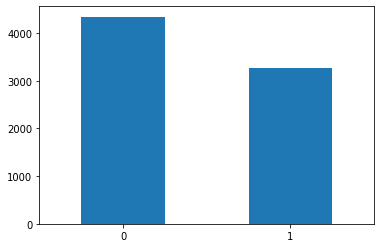

In [6]:
df.target.value_counts().plot(kind = 'bar', rot = 0)

While this ratio is by no means disastrous, we can still perform some light data cleaning here by randomly sampling our non-disaster tweets to completely even our class distributions for our classifier.

In [7]:
sampdf = df[df.target == 0].sample(n = len(df[df.target == 1]), random_state = 54322) #sample to equalize the ratio
sampdf = sampdf.append(df[df.target == 1], ignore_index = True) #add on the rows where target == 1 to our sampled dataframe
print(len(sampdf) == 2 * len(df[df.target == 1]))
print(len(sampdf), len(df[df.target == 1]))

True
6542 3271


<AxesSubplot:>

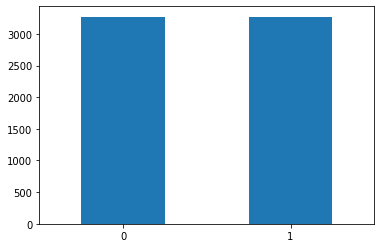

In [8]:
#Make sure it looks right
sampdf.target.value_counts().plot(kind = 'bar', rot = 0)

We now examine the keyword and location columns.  From this we can see that almost all of the tweets have a non-NaN keyword and around 2/3 of the tweets have a non-NaN location tag.

In [9]:
print(f"{round(sampdf.keyword.isna().sum() / len(sampdf) * 100,3)}% of the tweets have NaN values for keywords")
print(f"{round(sampdf.location.isna().sum() / len(sampdf) * 100,3)}% of the tweets have NaN values for locations")

0.856% of the tweets have NaN values for keywords
33.338% of the tweets have NaN values for locations


In [10]:
sampdf.keyword[sampdf.keyword.isna() == False].nunique()

221

Interestingly, while most the tweets have a keyword, they seem to be repeated quite a bit since we can see that there exist only 221 unique keywords in the entire training set that are not NaNs.  This could be quite interesting to look in to, and it could be that there exists a correlation between specific keywords and the disaster status of a tweet.  With that said, this notebook will focus on only the textual data with the keywords and locations being ignored for the time being.

In [11]:
print(len(sampdf.dropna(subset = ['text'])), len(sampdf)) #check if there exist any nans in the texts
print(len(sampdf.drop_duplicates(subset = ['id', 'text'])), len(sampdf)) #check if there exist and duplicate tweets

6542 6542
6542 6542


We can see that there aren't any NA values in our important 'text' column, nor do there seem to be any repeated tweets.

We begin preprocessing our tweet text data.  This first function uses the tweet-preprocessor's .clean function to remove hashtags, emojis, and URLs.  It is important to note that there is a good chance that the hashtags contain valuable information as to the 'realness' of a disaster just as the keyword column could.  For this small mini-project we will be ignoring this possiblity for now but this could be a great step to check to imporove accuracy in future work.  There could also be some merit in checking if the emojis have some correlation to the disaster status as well.

In [13]:
#row-by-row cleaning via tweet-preprocessor's .clean function
#removes hashtags, emojis, and URLS
def preproc(row):
    text = row['text']
    text = p.clean(text)
    return text

sampdf['text'] = sampdf.apply(preproc, axis = 1)

Next we do some 'normal' text preprocessing such as removing whitespace, lowercasing, removing stopwords, and lemmatizing words.

In [14]:
#tweet-specific stuff done, now need to do more 'normal' text preprocessing
lemmatizer = WordNetLemmatizer()
def text_preproc(row):
    text = row['text']
    text = text.lower() #set to lowercase
    text = text.strip() #remove whitespace
    text = text.encode('ascii', errors = 'ignore').decode() #remove non-ascii characters
    text = re.sub(r'\d+', '', text) #remove numbers
    text = re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~.\'!?]+','',text) #remove all punctuation 
    
    stops = set(stopwords.words('english')) #set of stopwords to compare to
    #following line does quite a bit.  takes words from text, and if they are longer than 1 character and not a stop word then they join them back together
    #using the lemmatized versions of the words in to a new string
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if (word not in stops) and len(word) > 1])
    
    return text

sampdf['text'] = sampdf.apply(text_preproc, axis = 1)

Remove all columns except 'text' and 'target' from our training df.

In [15]:
#since we aren't using the other columns right now, lets just keep the two that do matter
cleandf = sampdf[['text', 'target']]
cleandf.head()

,text,target
0,gulfport energy allin realization fall cliff,0
1,let go passenger,0
2,big baby climbed thing wheels(io hawk)his knee...,0
3,there choking hazard dont die get,0
4,emergency dispatcher boone county hot seat,0


Now we can examine a few of the cleaned texts for each class.

In [16]:
cleandf[cleandf.target == 1][:10].text #target == 1

3271                      deed reason may allah forgive u
3272                forest fire near la ronge sask canada
3273    resident asked shelter place notified officer ...
3274           people receive evacuation order california
3275               got sent photo ruby smoke pours school
3276    update california hwy closed direction due lak...
3277    heavy rain cause flash flooding street manitou...
3278                            im top hill see fire wood
3279    there emergency evacuation happening building ...
3280                        im afraid tornado coming area
Name: text, dtype: object

In [17]:
cleandf[cleandf.target == 0][:10].text #target == 0

0         gulfport energy allin realization fall cliff
1                                     let go passenger
2    big baby climbed thing wheels(io hawk)his knee...
3                    there choking hazard dont die get
4           emergency dispatcher boone county hot seat
5    im traumatised cant even spell properly excuse...
6    ignition knock (detonation) sensorsenso standa...
7        lol real issue way nfl trying ruin guy legacy
8    even berlin wall survived daubt theyll ever ge...
9    congress renamed italian goonda party motley c...
Name: text, dtype: object

Something that will be useful to know is the maximum number of words that remain in our cleaned data's tweets.  We'll assess this below.

In [18]:
#take training data, get longest # words, use that as maxlen
cleandf['totwords'] = [len(x.split()) for x in cleandf['text'].tolist()]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:>

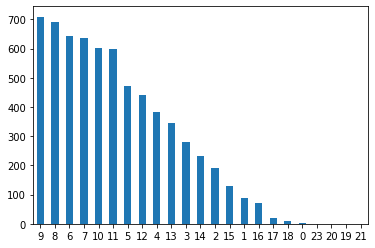

In [141]:
cleandf.totwords.value_counts().plot(kind = 'bar', rot = 0)

The longest tweet remaining has 23 words in it, while most of the tweets have around 9 to 11 words in them after cleaning.  No tweets have less than 9 words after cleaning, which is quite interesting.  I wouldn't assume that a lot of them would, but I would have assumed that there would be at least a few from, say, a short tweet that got overly cleaned.

We can also examine the distribution of the word counts here.

['fire', 'like', 'amp', 'im', 'via', 'get', 'new', 'people', 'dont', 'one']


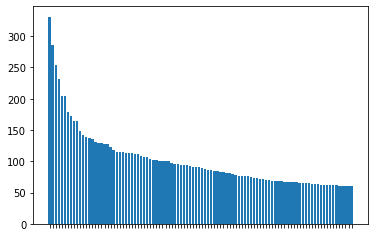

In [155]:
counts = Counter(" ".join(cleandf["text"]).split()).most_common(100) #get top 100 most common words in corpus after cleaning
res = [[i for i, j in counts], [j for i, j in counts]]
plt.bar(res[0], res[1], tick_label = "")
print(res[0][:10])

Above we can see the distribution of the top 100 words for the entirety of the cleaned training data, along with the top 10 words themselves.  We can do this same thing for the data where the target is 1 (it is a real disaster) and where target is 0 (it is not a real disaster).

['fire', 'via', 'california', 'suicide', 'disaster', 'amp', 'people', 'police', 'family', 'train']


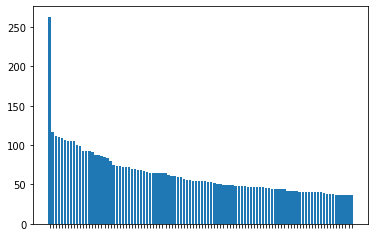

In [157]:
counts = Counter(" ".join(cleandf[cleandf['target'] == 1].text).split()).most_common(100) #get top 100 most common words in corpus after cleaning
res = [[i for i, j in counts], [j for i, j in counts]]
plt.bar(res[0], res[1], tick_label = "")
print(res[0][:10])

['like', 'im', 'amp', 'get', 'new', 'dont', 'one', 'body', 'via', 'time']


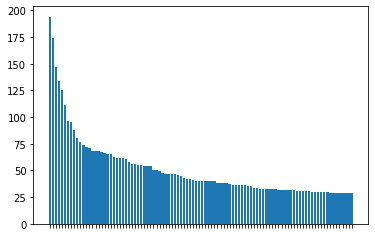

In [158]:
counts = Counter(" ".join(cleandf[cleandf['target'] == 0].text).split()).most_common(100) #get top 100 most common words in corpus after cleaning
res = [[i for i, j in counts], [j for i, j in counts]]
plt.bar(res[0], res[1], tick_label = "")
print(res[0][:10])

Clearly 'fire' will be a great word as a predictor!

Now that we have a cleaned dataframe and a good understanding of the distribution of words within, we can start to look towards our modeling steps.

## Step 3 - Architecture
##### Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.  


After some reading I decided to utilize at least one LSTM layer in my model.  This is due to the fact that LSTMs are incredibly useful for linking words across cycles, which is exactly what I believe would be important here.  Having key indicator words seperated by other 'noisy' words could be troublesome for many models but LSTMs have the ability to parse through these types of problems while maintaining the sequences of the important words.  For example, something like "That scary fire sure did destroy so many buildings" may be broken up by other modeling techniques and lose the connections between 'fire' and 'destroy' due to the intermediary 'sure did' phrase.  LSTMs would avoid this issue.  This is why they are also so widely used in language generation, voice recognition, etc. and what would make them very well suited to our task here.  
Since we want to keep the sequences of words intact for our LSTM to interpret a tfidf transformation does not seem to be the best choice for our embedding, instead I have chosen to use a uniform embedding layer using inputs from the basic keras text vectorization.  
<br />

In selecting the final model that I used there were many, many iterations of hyperparameter tuning and architecture choice that I have decided to cut out of the notebook since it is already quite packed.  I've selected a few examples to remain, commented out and ready for re-running as needed and with some resulting graphs kept in place for a quick comparison.  
<br />

With that said, I will quickly walk through some of the iterations of my architecture.
I began by noting that simpler is, usually, better - assuming that I can get similar results with simpler models of course.  As such my first models were simply an embedding, lstm, and dense layer with a sigmoid activation function.  With this basic architecture I compared results from different optimizers (Adam, SGD, Adamax, etc).  I found similar results for many of these but with Adam being the quickest to converge and with some nice hyperparameters for further adaptive learning rate tuning.  As such my future attempts utilized the Adam optimizer. 
Next I experimented between having ngrams of 1 or 2 in my text vectorization.  Having ngrams of 2 made the most sense to me as it seems quite easy for some nuance to be lost when utilizing only unigrams.  For example "this is fire" vs. "a terrible fire".  I was worried that unigrams may lose this kind of nuance even with the utilization of an LSTM layer.  In the end, I did not find tremendous improvement by allowing for ngrams of 2, but there was some improvement and with hardly any increase in training time so it was kept.  
Following this I experimented with adding additional LSTM and Dense layers of differing input/output sizes and, in the case of the LSTM, with different dropouts (or lack thereof).  This hyperparameter tuning where quite a bit of output was deleted out of space concerns in the notebook.  In the end I decided on using an LSTM with a 20% dropout, followed by a relu activated Dense layer, a 20% dropout layer, a relu activated Dense layer, and a final sigmoid activated Dense layer for my classification.  
There was then some more hyperparameter optimization with my Adam optimizer, attempting to find the best initial learning rate as well as appropriate exponential decay rates for the first and second moment estimates so as to get a smooth and quick LR curve.  My final choice here was an initial learning rate of 0.000005 with decay rates of 0.9 for both the first and second moment estimates.
<br />

This final architecture allowed us to have a smooth learning rate curve, a relatively fast fit, and comparable to slightly better results to previous models with differing hyperparameters and architectures.  This chosen model also has the benefit of being simpler than many other models which ended with similar performance metrics which indicates that it is better overall.  
Because I hadn't worked much with RNNs of any kind previously the initial guesses for my hyperparameters were from looking at others' code and reading from similar problems but in the end it was through trial and error that these specific parameters and architecture were selected for this specific problem.  

In [20]:
cleandf.head()

,text,target,totwords
0,gulfport energy allin realization fall cliff,0,6
1,let go passenger,0,3
2,big baby climbed thing wheels(io hawk)his knee...,0,16
3,there choking hazard dont die get,0,6
4,emergency dispatcher boone county hot seat,0,6


In [46]:
traindf, validdf = train_test_split(cleandf[['text', 'target']], test_size = 0.2)

In [47]:
traindf.head()

,text,target
2372,court back session testimony continues med exa...,0
857,handbag genuine mulberry antony cross body mes...,0
1711,thought friday day today beyond devastated rea...,0
1121,liked video gun range mayhem,0
1747,mega mood swing hr schedule isnt structural fa...,0


Adam optimizer, embedding, lstm, dense, dense layers, ngrams of 1

In [48]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, ngrams = 1)
# encoder.adapt(traindf.map(lambda text, label: text))
encoder.adapt(traindf.text)
vocab = np.array(encoder.get_vocabulary())

In [49]:
model = Sequential(encoder)
model.add(Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero = True))
model.add(LSTM(64, dropout = 0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.0001) , metrics = ['accuracy'])

In [50]:
my_callbacks = EarlyStopping(patience = 2)

In [159]:
# history = model.fit(x = traindf.text, y = traindf.target, epochs = 200, validation_data = (validdf.text, validdf.target), callbacks = my_callbacks)

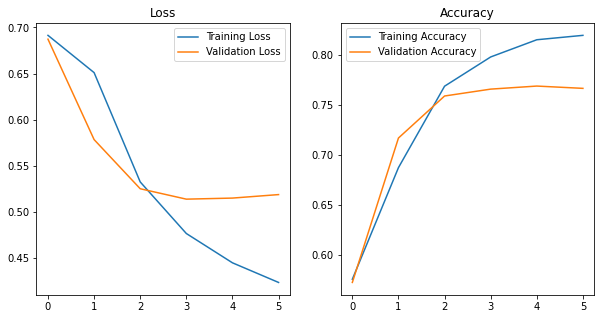

In [52]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].set_title('Loss')
axs[0].plot(history.epoch, history.history['loss'], label = 'Training Loss')
axs[0].plot(history.epoch, history.history['val_loss'], label = 'Validation Loss')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history.epoch, history.history['accuracy'], label = 'Training Accuracy')
axs[1].plot(history.epoch, history.history['val_accuracy'], label = 'Validation Accuracy')
axs[1].legend()

Adam optimizer, lower initial learning rate, embedding, lstm, dense, dense layers, ngrams of 2

In [53]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, ngrams = 2)
# encoder.adapt(traindf.map(lambda text, label: text))
encoder.adapt(traindf.text)
vocab = np.array(encoder.get_vocabulary())

In [54]:
model = Sequential(encoder)
model.add(Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero = True))
model.add(LSTM(64, dropout = 0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.00001) , metrics = ['accuracy'])

In [160]:
# history = model.fit(x = traindf.text, y = traindf.target, epochs = 200, validation_data = (validdf.text, validdf.target), callbacks = my_callbacks)

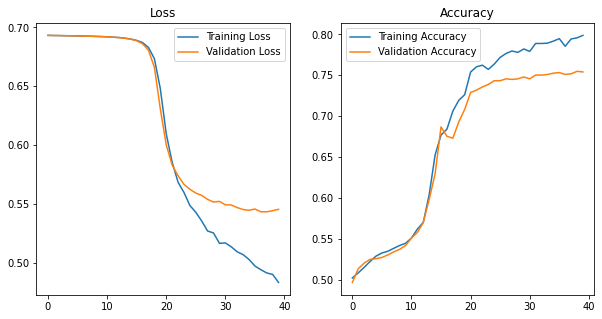

In [56]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].set_title('Loss')
axs[0].plot(history.epoch, history.history['loss'], label = 'Training Loss')
axs[0].plot(history.epoch, history.history['val_loss'], label = 'Validation Loss')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history.epoch, history.history['accuracy'], label = 'Training Accuracy')
axs[1].plot(history.epoch, history.history['val_accuracy'], label = 'Validation Accuracy')
axs[1].legend()

adam optimizer, lr = 0.00001, bidirectional LSTM, dense, dense

In [60]:
model = Sequential(encoder)
model.add(Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero = True))
model.add(Bidirectional(LSTM(64, dropout = 0.2)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.00001) , metrics = ['accuracy'])

In [161]:
# history = model.fit(x = traindf.text, y = traindf.target, epochs = 200, validation_data = (validdf.text, validdf.target), callbacks = my_callbacks)

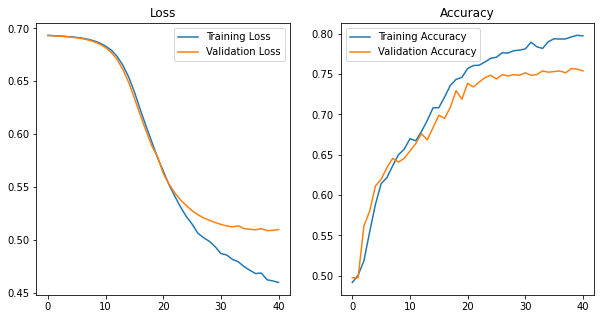

In [62]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].set_title('Loss')
axs[0].plot(history.epoch, history.history['loss'], label = 'Training Loss')
axs[0].plot(history.epoch, history.history['val_loss'], label = 'Validation Loss')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history.epoch, history.history['accuracy'], label = 'Training Accuracy')
axs[1].plot(history.epoch, history.history['val_accuracy'], label = 'Validation Accuracy')
axs[1].legend()


adam optimizer, lr = 0.00001, bidirectional, lower output dim, dense, dense

In [63]:
model = Sequential(encoder)
model.add(Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 23, mask_zero = True))
model.add(Bidirectional(LSTM(23, dropout = 0.2)))
model.add(Dense(23, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.00001) , metrics = ['accuracy'])

In [162]:
# history = model.fit(x = traindf.text, y = traindf.target, epochs = 200, validation_data = (validdf.text, validdf.target), callbacks = my_callbacks)

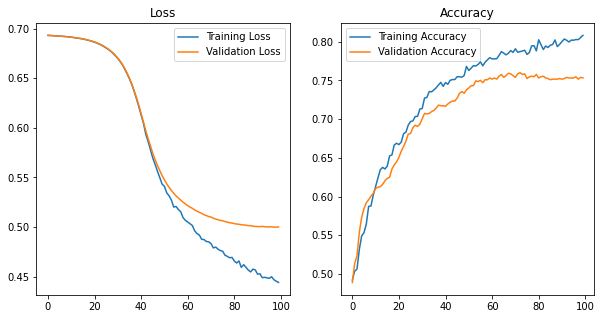

In [65]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].set_title('Loss')
axs[0].plot(history.epoch, history.history['loss'], label = 'Training Loss')
axs[0].plot(history.epoch, history.history['val_loss'], label = 'Validation Loss')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history.epoch, history.history['accuracy'], label = 'Training Accuracy')
axs[1].plot(history.epoch, history.history['val_accuracy'], label = 'Validation Accuracy')
axs[1].legend()


Lstm, dense, dense, dense lowering output by layer, adam optimizer, lr = 0.00001

In [69]:
model = Sequential(encoder)
model.add(Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero = True))
model.add((LSTM(64, dropout = 0.2)))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.00001) , metrics = ['accuracy'])

In [163]:
# history = model.fit(x = traindf.text, y = traindf.target, epochs = 200, validation_data = (validdf.text, validdf.target), callbacks = my_callbacks)

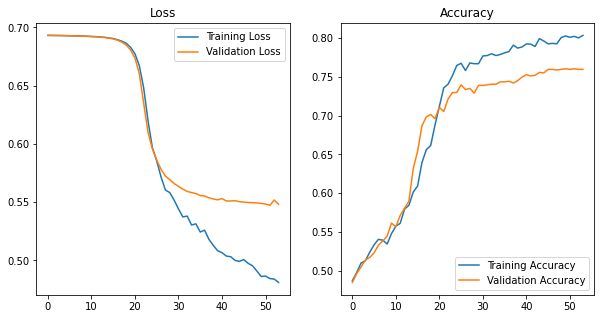

In [71]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].set_title('Loss')
axs[0].plot(history.epoch, history.history['loss'], label = 'Training Loss')
axs[0].plot(history.epoch, history.history['val_loss'], label = 'Validation Loss')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history.epoch, history.history['accuracy'], label = 'Training Accuracy')
axs[1].plot(history.epoch, history.history['val_accuracy'], label = 'Validation Accuracy')
axs[1].legend()


Above was decent, but with a bit of a steep drop in our val loss followed by a plateau

In [77]:
my_callbacks = [EarlyStopping(patience = 2), ReduceLROnPlateau(factor = 0.1, min_lr = 0.000001, monitor = 'val_loss', verbose = 1, patience = 10)]

In [110]:
model = Sequential(encoder)
model.add(Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 128, mask_zero = True))
model.add((LSTM(128, dropout = 0.2)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.00001) , metrics = ['accuracy'])

In [164]:
# history = model.fit(x = traindf.text, y = traindf.target, epochs = 200, validation_data = (validdf.text, validdf.target), callbacks = my_callbacks)

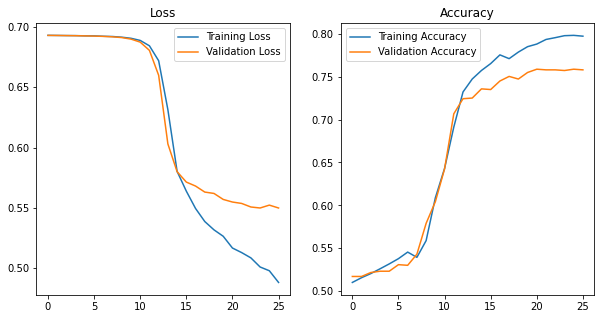

In [112]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].set_title('Loss')
axs[0].plot(history.epoch, history.history['loss'], label = 'Training Loss')
axs[0].plot(history.epoch, history.history['val_loss'], label = 'Validation Loss')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history.epoch, history.history['accuracy'], label = 'Training Accuracy')
axs[1].plot(history.epoch, history.history['val_accuracy'], label = 'Validation Accuracy')
axs[1].legend()

recurrent dropout = 0.2 gives worse results, much slower.  delete cell for now.

In [115]:
model = Sequential(encoder)
model.add(Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 128, mask_zero = True))
model.add((LSTM(128, dropout = 0.2)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.00005) , metrics = ['accuracy'])

Keep output here since it's tiny and it can be used to show that it converged far too quickly

In [116]:
history = model.fit(x = traindf.text, y = traindf.target, epochs = 200, validation_data = (validdf.text, validdf.target), callbacks = my_callbacks)

Epoch 1/200
164/164 [==============================] - 8s 18ms/step - loss: 0.6930 - accuracy: 0.5173 - val_loss: 0.6926 - val_accuracy: 0.5248
Epoch 2/200
164/164 [==============================] - 2s 12ms/step - loss: 0.6922 - accuracy: 0.5404 - val_loss: 0.6913 - val_accuracy: 0.5355
Epoch 3/200
164/164 [==============================] - 2s 11ms/step - loss: 0.6802 - accuracy: 0.6134 - val_loss: 0.6215 - val_accuracy: 0.7051
Epoch 4/200
164/164 [==============================] - 2s 11ms/step - loss: 0.5704 - accuracy: 0.7447 - val_loss: 0.5455 - val_accuracy: 0.7464
Epoch 5/200
164/164 [==============================] - 2s 11ms/step - loss: 0.5166 - accuracy: 0.7810 - val_loss: 0.5392 - val_accuracy: 0.7571
Epoch 6/200
164/164 [==============================] - 2s 11ms/step - loss: 0.4876 - accuracy: 0.7904 - val_loss: 0.5308 - val_accuracy: 0.7586
Epoch 7/200
164/164 [==============================] - 2s 11ms/step - loss: 0.4633 - accuracy: 0.8030 - val_loss: 0.5249 - val_accuracy:

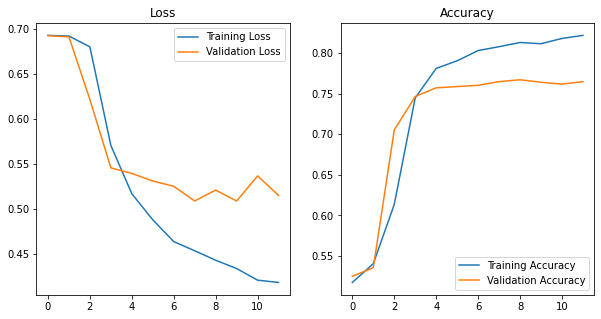

In [117]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].set_title('Loss')
axs[0].plot(history.epoch, history.history['loss'], label = 'Training Loss')
axs[0].plot(history.epoch, history.history['val_loss'], label = 'Validation Loss')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history.epoch, history.history['accuracy'], label = 'Training Accuracy')
axs[1].plot(history.epoch, history.history['val_accuracy'], label = 'Validation Accuracy')
axs[1].legend()

Above clearly had too high of an LR

Final model below, adjusts the decay rate for moment estimtes, lowers learning rate.  
LSTM, dense, dropout, dense, dense(classifier)

In [121]:
model = Sequential(encoder)
model.add(Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 128, mask_zero = True))
model.add((LSTM(128, dropout = 0.2)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.000005, beta_1 = 0.9, beta_2 = 0.9) , metrics = ['accuracy'])

In [165]:
# history = model.fit(x = traindf.text, y = traindf.target, epochs = 200, validation_data = (validdf.text, validdf.target), callbacks = my_callbacks)

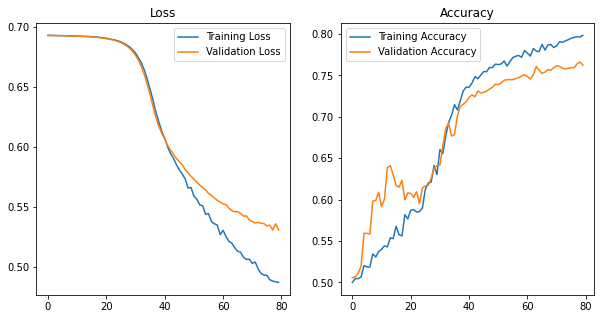

In [123]:
fig, axs = plt.subplots(1, 2, figsize = (10,5))
axs[0].set_title('Loss')
axs[0].plot(history.epoch, history.history['loss'], label = 'Training Loss')
axs[0].plot(history.epoch, history.history['val_loss'], label = 'Validation Loss')
axs[0].legend()

axs[1].set_title('Accuracy')
axs[1].plot(history.epoch, history.history['accuracy'], label = 'Training Accuracy')
axs[1].plot(history.epoch, history.history['val_accuracy'], label = 'Validation Accuracy')
axs[1].legend()

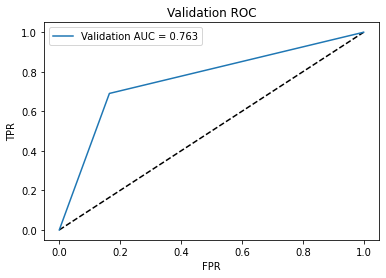

In [132]:
predicted_validation = [1 if val >= 0.5 else 0 for val in model.predict(validdf.text)]
fpr_valid, tpr_valid, thresh_valid = roc_curve(validdf.target, predicted_validation)
auc_valid = auc(fpr_valid, tpr_valid)

plt.figure(1)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_valid, tpr_valid, label = f'Validation AUC = {round(auc_valid,3)}')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Validation ROC")
plt.legend()
plt.show()

## Creating Kaggle Submission

In [133]:
testdf = pd.read_csv(test_path)
testdf = testdf[['id','text']]
testdf.head()
# print(len(testdf)) #3263

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [134]:
testdf['text'] = testdf.apply(text_preproc, axis = 1) #clean testdf
testdf['text'] = testdf.apply(preproc, axis = 1) #clean testdf

In [135]:
# testdf.head()
testdf['target'] = [1 if val >= 0.5 else 0 for val in model.predict(testdf.text)]
testdf.head()

,id,text,target
0,0,happened terrible car crash,1
1,2,heard earthquake different city stay safe ever...,1
2,3,forest fire spot pond goose fleeing across str...,1
3,9,apocalypse lighting spokane wildfire,1
4,11,typhoon soudelor kill china taiwan,1


In [136]:
# testdf.to_csv('predictions_final.csv', columns = ['id','target'], index= False) #save the predictions for kaggle

## Step 4 - Results and Analysis
The hyperparameter tuning and architecure comparison was done above, with some of the results kept (and not commented out) so as to display some visualizations for comparison between the remaining models.  Since most of that is above, this section will speak on a few specific models and why they were not chosen as the final model to be used.  
<br />
The second to last model which had the following architecture: 

model = Sequential(encoder)  
model.add(Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 128, mask_zero = True))  
model.add((LSTM(128, dropout = 0.2)))  
model.add(Dense(64, activation = 'relu'))  
model.add(Dropout(0.2))  
model.add(Dense(32, activation = 'relu'))  
model.add(Dense(1, activation = 'sigmoid'))  
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.00005) , metrics = ['accuracy'])  

Was suboptimal because it converged far too quickly.  This was indicative of my model having too high of a learning rate.  This is further confirmed by the 'bouncing around' of the loss in the graph even in just the few epochs that remained before early stopping finished the compiling.  To combat this, the following (and final) model adjusted the exponential decay rates for the moment estimates in our Adam optimizer.  This allowed for a much slower, controlled descent in our loss over the epochs.  
<br />

Comparing this to our first model (that is kept in the notebook) which had the following architecture:

model = Sequential(encoder)  
model.add(Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero = True))  
model.add(LSTM(64, dropout = 0.2))  
model.add(Dense(64, activation = 'relu'))  
model.add(Dense(1, activation = 'sigmoid'))  
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.0001) , metrics = ['accuracy'])  
Here we saw a case of overfitting right after the second epoch of training.  The training accuracy continued to increase quite quickly while the validation accuracy plateaued.  We also see the loss doing the same but in a decreasing manner.  
<br />

As mentioned previously, the methodology for tuning was to take a first guess with a simple model and then iterate through changes slowly working towards the best possible model with my given data.  While many of the intermediary steps were taken out of the notebook, enough were left in to allow one to follow through the basic gist of how these steps were performed, and a textual description was given in the previous text block entitled 'Step 3 - Architecture'.  The visualization results were kept by each model architecture in the notebook above and will not be re-printed in this section. 

The final model had a maximum validation accuracy of around 75% and an AUC of around 0.76  
The validation accuracy was comparable to other, previous architectures / hyperparameters, but it converged in a way that was more satisfactory (converged more steadily, less bouncing around) while still being relatively quick.

## Step 5 - Conclusion

As just mentioned, my final model ended with a similar validation accuracy to previous attempts but was chosen over the others due to the way in which the model converged.  Previous attempts would shoot straight to 75% then bounce around indicating an improper learning rate, or some wouldn't converge at all after 200 epochs of training.  This final model struck a nice middle ground in the time it took while converging neatly and giving satisfactory results.  In the Kaggle submission it achieved a score of 77.4%
One thing which would have greatly sped up the results would have been working with similar models before.  As it was, this was my first real forray in to RNNs and so my initial models and hyperparameters were chosen almost arbitrarily (with some reference to readings and comparable projects) and I was made to hone in on the proper set up for this specific problem.  In future works with similar models I now have some basis of understanding for how to more concicely do hyperparameter tuning and architecture selection.   
Something which surprised me was the lack of a need to include larger ngrams in my tokenization.  While this was mentioned earlier and it was noted that it could be explained by my LSTM layer 'keeping track' of sequences of words, I still would have expected a larger increase in accuracy if it was allowed to keep track of phrases (bigrams) rather than only words (unigrams).  
To improve on this model the most immediate thought would be to keep hashtags, something which I immediately took out of my data at the start in the data cleaning steps.  I think that hashtags could carry quite a bit of value and could allow my model to approach the higher end of the submitted notebooks in this kaggle project.  Keeping the keywords and incorporating their information could also help in the same way.  I'm unsure if the location data would have the biggest impact, but that could be another avenue to approach for future improvement of the model.  